In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from scipy import stats

In [2]:
cmap_seis = cm.get_cmap(name='seismic')
cmap_cool = cm.get_cmap(name='plasma')
cmap_jet = cm.get_cmap(name='jet')
RPMs = [1500,2000,2500,3000,4000,5000,6000,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000,13000,14000]
THROTs = [0,4,8,13,18,25,33,41,50,59,68,77,86,95]
xmax = 14000
ymin = 0
ymax = 101
xi, yi = np.meshgrid([0,4,8,13,18,25,33,41,50,59,68,77,86,95],
                     [1500,2000,2500,3000,4000,5000,6000,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000,13000,14000]
                     )
bth = np.array([0,4,8,13,18,25,33,41,50,59,68,77,86,95,101])
brpm=np.array([0,1500,2000,2500,3000,4000,5000,6000,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000,13000,14000])

In [3]:
# Acquisition DTA
dateparse = lambda x: pd.Timedelta(minutes=pd.to_numeric(x.split(':')[0]), seconds=pd.to_numeric(x.split(':')[1].replace(",", ".")))
acquisition = pd.read_csv("ACCELcme.Dat", sep=';', decimal=',', parse_dates=[1,], date_parser=dateparse)
#acquisition= acquisition[acquisition['LAMB']> 0.6]

## Détection de points stationnaires

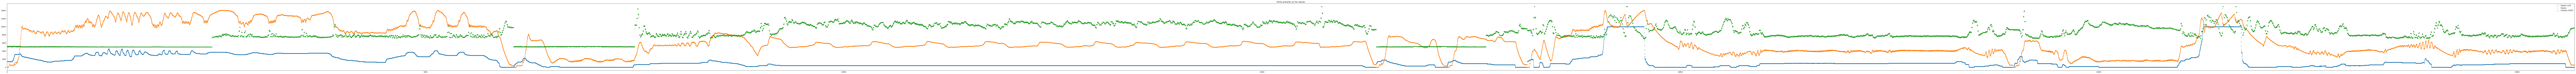

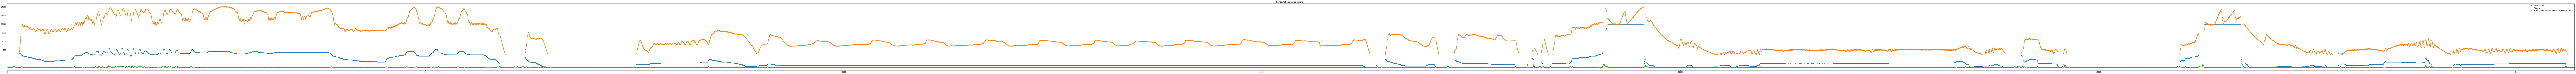

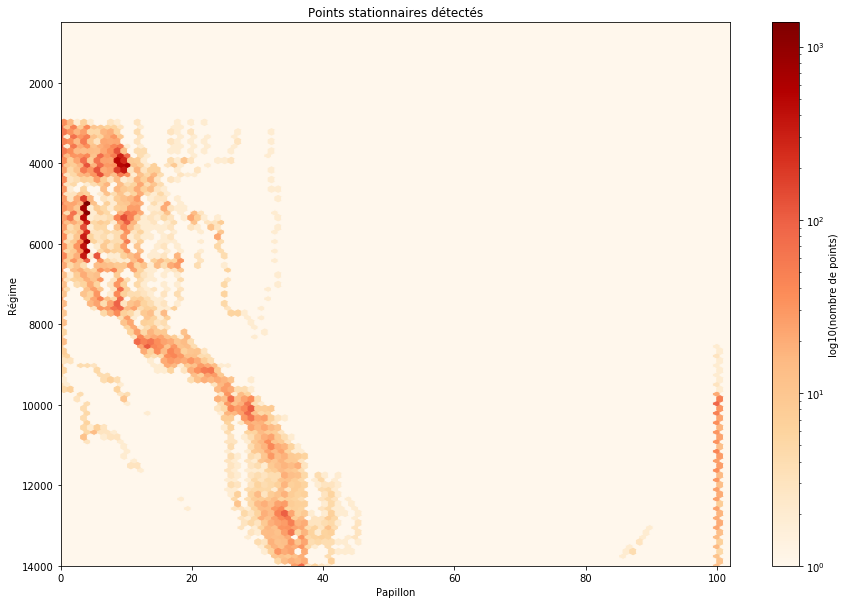

In [4]:
tmin = 0
tmax = 102
rmin = 500
rmax = 14000
stdlim = 1.2
larg_fen = 9
plt.figure(figsize=(300, 8))
ff = acquisition
df_std = ff["THROT"].rolling(larg_fen).std()
#ff["THROT"] = ff["THROT"].rolling(10).mean()
plt.plot(ff["THROT"]*100, '.', label="Papillon x100")
plt.plot(ff["RPM"], '.', label="Régime")
#plt.plot(df_std*100, '.', label="Écart type du papillon, fenêtre sur %s mesures x100" % larg_fen)
plt.plot(ff["LAMB"]*10000, '.', label="Lambda x10000")
#plt.plot(np.minimum(ff["EXT 5V"]*1000, 16000), '.', label="LUSP x10")
plt.title("Points présents sur les relevés")
plt.xlim(0, max(acquisition.index))
#plt.savefig("graphe4.jpg", bbox_inch='tight', dpi=350)
plt.legend()
plt.show()

plt.figure(figsize=(300, 8))


df_ss = ff[(ff["RPM"]>3000) & ((df_std < stdlim))]
plt.plot(df_ss["THROT"]*100, '.', label="Papillon x100")
plt.plot(df_ss["RPM"], '.', label="Régime")
plt.plot(df_std*100, '.', label="Écart type du papillon, fenêtre sur %s mesures x100" % larg_fen)
plt.title("Points stationaires sélectionnés")
plt.xlim(0, max(acquisition.index))
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
plt.gca().invert_yaxis()
hb = ax.hexbin(df_ss["THROT"], df_ss["RPM"], gridsize=100, bins='log', cmap='OrRd', extent=(tmin, tmax, rmin, rmax))
ax.axis([tmin, tmax, rmax, rmin])
ax.set_title("Points stationnaires détectés")
ax.set_xlabel("Papillon")
ax.set_ylabel("Régime")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(nombre de points)')

# plt.savefig("run4.jpg", bbox_inch='tight', dpi=350)
plt.show()

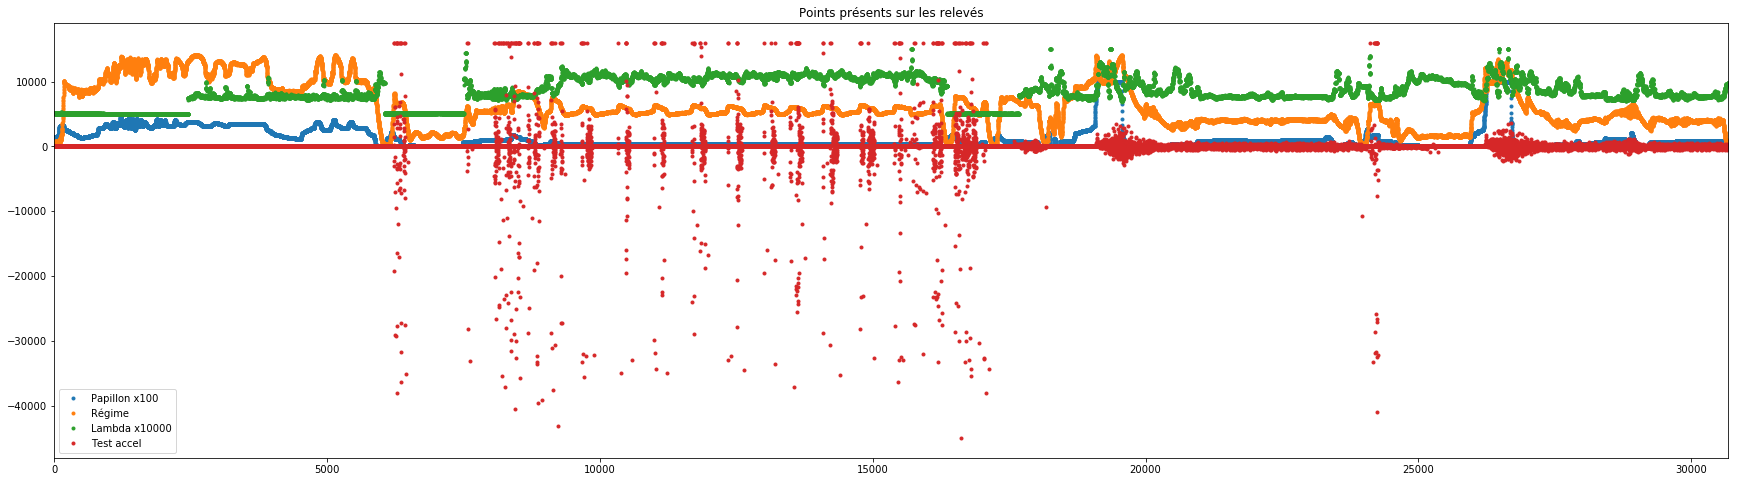

In [5]:
stdlim = 1.2
larg_fen = 9
plt.figure(figsize=(30, 8))
ff = acquisition
df_std = ff["THROT"].rolling(larg_fen).std()
#ff["THROT"] = ff["THROT"].rolling(10).mean()
plt.plot(ff["THROT"]*100, '.', label="Papillon x100")
plt.plot(ff["RPM"], '.', label="Régime")
plt.plot(ff["LAMB"]*10000, '.', label="Lambda x10000")
plt.plot(np.minimum(ff["L U SP"].diff()/.1*100, 16000), '.', label="Test accel")
plt.title("Points présents sur les relevés")
plt.xlim(0, max(acquisition.index))
#plt.savefig("graphe4.jpg", bbox_inch='tight', dpi=350)
plt.legend()
plt.show()

## Richesse du mélange sur les points sélectionnés

Ce dessous une interpolation des valeurs de lambda moyennes

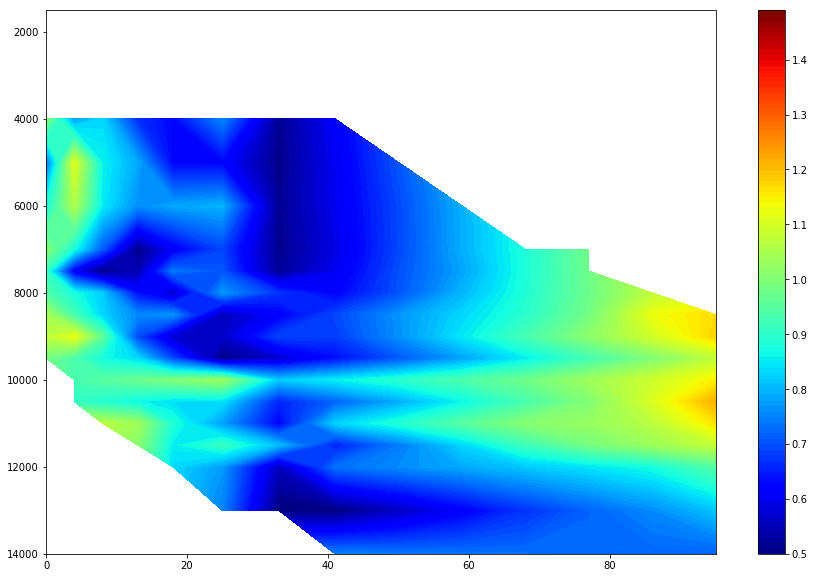

In [6]:
fig = plt.figure(figsize=(15, 10))
plt.gca().invert_yaxis()
n_levels= 3

#ff = acquisition.groupby(["RPM", "THROT"], as_index=False).mean()
ff = df_ss.groupby(["RPM", "THROT"], as_index=False).mean()
x = ff["THROT"]
y = ff["RPM"]
triang = mtri.Triangulation(x, y)
z = ff["LAMB"] 
interp_lin = mtri.LinearTriInterpolator(triang, z)
zi_lin = interp_lin(xi, yi)

levels = np.arange(.5, 1.5, .01)
cmap = cm.get_cmap(name='jet')
plt.contourf(xi, yi, zi_lin, 
             cmap=cmap,
             levels=levels,
             )
plt.colorbar()
plt.show()

## Test de signification statistique 
Le premier graphique donne pour chaque case de carto une idée de la confiance que tu peux avoir en la valeur donnée : si une case indique un haut pourcentage, cela signifie que l'ensemble des mesures de lambda de cette case sont très localisés autour d'une valeur (à 0.02 près) et que tu peux avoir confiance en la valeur de lambda moyenne donnée. Un faible pourcentage indique que les valeurs sont  très dispersées et qu'il faut y accorder un faible crédit. Les pourcentages sont calculés grâce à des restes de souvenirs de cours de proba/stats (loi de Student).

Le deuxième graphique de montre le nombre de relevés qu'on a pour 1 case. Si dans une case le nombre est 1, cela signifie qu'il y a au moins 100 relevés pour cette case (donc que le résultats a des chances d'être significatif). Toutes les autres valeurs dans les cases correspondent au centième du nombre de relevés (0,52 signifie 52 relevés).

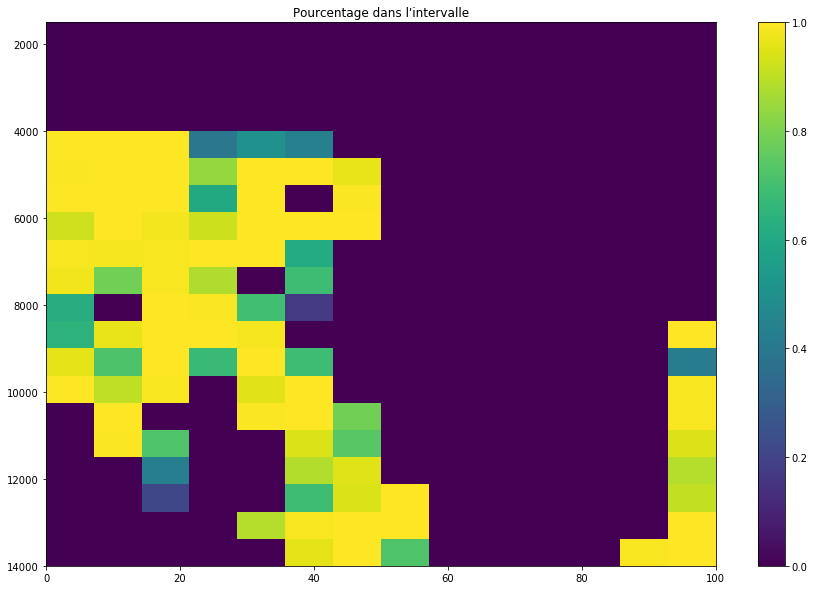

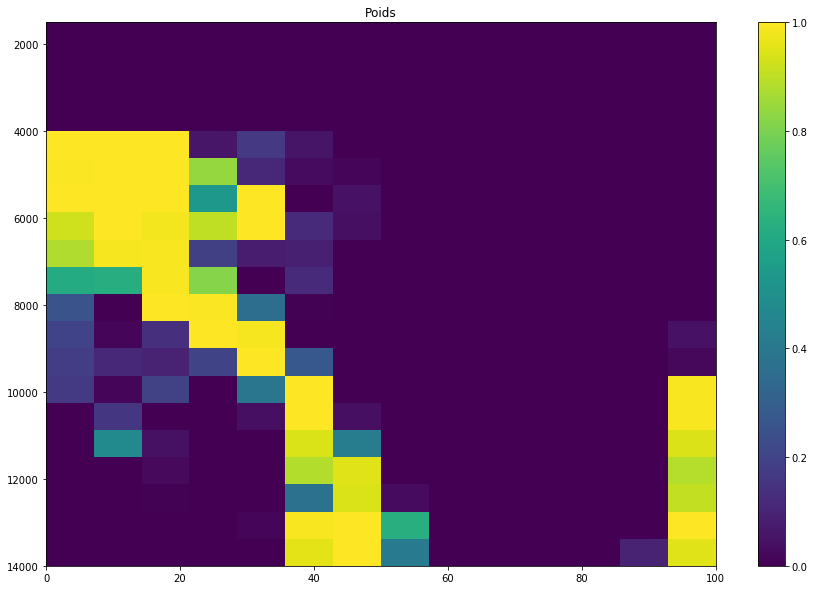

In [7]:
# Tests de stats
def interv(echantillon):
    if len(echantillon)<2:
        return 0
    delta_interv = 0.02
    S = np.sqrt(np.var(echantillon, ddof=1))
    racn = np.sqrt(len(echantillon))
    dl = len(echantillon)-1
    return 2*stats.t.cdf(delta_interv*racn/S, dl)-1


# Pourcentage interv
map_pourc = stats.binned_statistic_2d(df_ss['THROT'],
                        df_ss['RPM'],
                        df_ss['LAMB'],
                        statistic=interv,
                        bins=[bth,brpm]).statistic.T
fig = plt.figure(figsize=(15, 10))
plt.imshow(map_pourc,
          extent = (0,100,14000,1500),
          aspect="auto")
plt.colorbar()
plt.title("Pourcentage dans l'intervalle")
plt.show()

# Pourcentage comptage
map_compte = stats.binned_statistic_2d(df_ss['THROT'],
                        df_ss['RPM'],
                        df_ss['LAMB'],
                        statistic='count',
                        bins=[bth,brpm]).statistic.T
comptage = np.minimum(100,map_compte)/100
poids = comptage*map_pourc
fig = plt.figure(figsize=(15, 10))
plt.imshow(poids,
          extent = (0,100,14000,1500),
          aspect="auto")
plt.colorbar()
plt.title("Poids")
plt.show()